# 8.5 적대적 생성 신경망 소개
- **적대적 생성 신경망**(GAN) : 생성된 이미지가 실제 이미지와 통계적으로 거의 구분이 되지 않도록 강제하여 아주 실제 같은 합성 이미지를 생성
- GAN 네트워크
    - **생성자 네트워크**(generator network) : 랜덤 벡터(잠재 공간의 무작위한 포인트)를 입력으로 받아 이를 합성된 이미지로 디코딩
        - 판별자 네트워크를 속이도록 훈련하여 실제 이미지와 구분할 수 없는 인공적인 이미지를 만들어냄
    - **판별자 네트워크**(discriminator network)(또는 상대 네트워크) : 이지미(실제 또는 합성 이미지)를 입력으로 받아 훈련 세트에서 온 이미지인지, 생성자 네트워크가 만든 이미지인지 판별
        - 생성된 이미지가 실제인지 판별하는 기준을 설정하면서 생성자의 능력 향상에 적응해감
- GAN은 최적화의 최솟값이 고정되지 않은 시스템
- 최적화 과정이 보통의 경사 하강법처럼 최솟값을 찾는 것이 아닌 두 힘간의 평형점을 찾는 다이나믹 시스템
    - 이 때문에 훈련하기 어려움(모델 구조와 훈련 파라미터를 주의 깊게 많이 조정해야 함)

## 8.5.1 GAN 구현 방법
- 기본적인 내용만(깊게 들어가면 매우 어려워짐)
- 심층 합성곱 GAN(DCGAN)을 사용하며 이미지 업샘플링을 위해 `Conv2DTranspose` 층을 사용
- CIFAR10 데이터셋의 "frog" 클래스 이미지만 사용(32x32 RGB, 5000개 이미지)
- GAN 구조
    1. `generator` 네트워크는 `(latent_dim,)` 크기의 벡터를 `(32, 32, 3)` 크기의 이미지로 매핑
    2. `discriminator` 네트워크는 `(32, 32, 3)` 크기의 이미지가 진짜일 확률을 추정하여 이진 값으로 매핑
    3. 생성자와 판별자를 연결하는 `gan` 네트워크 생성  
       `gan(x) = discriminator(generator(x))` : 잠재 공간의 벡터를 판별자의 평가로 매핑
    4. "진짜"/"가짜" 레이블과 함께 진짜 이미지와 가짜 이미지 샘플을 사용하여 판별자를 훈련(이미지 분류 모델을 훈련하는 것과 동일)
    5. `gan` 모델의 손실에 대한 생성자 가중치의 그래디언트 사용  
       매 단계마다 생성자에 의해 디코딩된 이미지를 판별자가 "진짜"로 분류하도록 만드는 방향으로 생성자의 가중치를 이동

## 8.5.2 훈련 방법
- 이론이 아닌 경험을 통해 발견된 방법
    - 생성자의 마지막 활성화로 `sigmoid` 대신 `tanh` 함수 사용
    - 균등 분포가 아닌 정규 분포를 사용하여 잠재 공간에서 포인트를 샘플링
    - 무작위성을 주입 : 판별자에 드롭아웃을 사용하거나 판별자를 위해 레이블에 랜덤 노이즈를 추가
        - GAN 훈련은 동적 평형을 만들기 때문에 여러 방식으로 갇힐 가능성이 높으며 이를 방지하기 위해 무작위성을 주입
    - 스트라이드 합성곱과 `LeakyReLU` 층 사용
        - 희소한 그래디언트는 GAN 훈련을 방해하므로, 그래디언트를 희소하게 만들 수 있는 최대 풀링 연산을 스트라이드 합성곱으로 대체, `ReLU` 활성화 대신 `LeakyReLU` 층 사용
    - 생성자와 판별자에서 스트라이드 `Conv2DTranspose`나 `Conv2D`를 사용할 때 스트라이드 크기로 나누어질 수 있는 커널 크기를 사용
        - 생성자에서 픽셀 공간을 균일하게 다루지 못하여 생성된 이미지에서 체스판 모양이 종종 나타나기 때문

## 8.5.3 생성자
- 생성자가 노이즈 같은 이미지를 생성하는 데서 멈추는 것을 방지하기 위하여 드롭아웃 추가

### GAN 생성자 네트워크

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = tf.keras.Input(shape=(latent_dim,))

# 입력을 16x16 크기의 채널 128개를 가진 특성 맵으로 변환
x = layers.Dense(128*16*16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 32x32 크기로 업샘플링
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 32x32 크기의 1개 채널을 가진 특성 맵 생성
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = tf.keras.models.Model(generator_input, x) # (latent_dim,) 크기의 입력을 (32, 32, 3) 크기의 이미지로 매핑하는 생성자 모델 객체 생성
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       104883

## 8.5.4 판별자
- '생성된 이미지' 또는 '훈련 세트에서 온 진짜 이미지' 클래스를 판별하는 모델

### GAN 판별자 네트워크

In [2]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# 드롭아웃 추가
x = layers.Dropout(0.4)(x)

# 분류 층
x = layers.Dense(1, activation='sigmoid')(x)

# (32, 32, 3) 크기의 입력을 이진 분류 결정(진짜/가짜)으로 변환하는 판별자 모델 객체 생성
discriminator = tf.keras.models.Model(discriminator_input, x)
discriminator.summary()

discriminator_optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=0.0008,
    clipvalue=1.0, # 옵티마이저에서 (값을 지정하여) 그래디언트 클리핑 사용
    decay=1e-8) # 안정된 훈련을 위해서 학습률 감쇠를 사용
discriminator.compile(optimizer=discriminator_optimizer,
                      loss='binary_crossentropy')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6, 6, 128)         0   

## 8.5.5 적대적 네트워크
- 생성자와 판별자를 연결하여 GAN을 설정
- 훈련할 때 생성자가 판별자를 속이는 능력이 커지도록 학습
- 훈련에 사용되는 타깃 레이블은 항상 '진짜 이미지'
- `gan`을 훈련하는 것은 `discriminator`가 가짜 이미지를 보았을 때 진짜라고 예측하도록 만들기 위해 `generator`의 가중치를 업데이트 하는 것
- 훈련하는 동안 판별자를 동결시켜야 함
    - 그렇지 않으면 판별자는 항상 "진짜"를 예측하도록 훈련됨

### 적대적 네트워크

In [4]:
# 판별자의 가중치가 훈련되지 않도록 설정
# gan 모델에만 적용되며 (모델이 다른 모델에 층처럼 추가되었을 때 학습되지 않도록 함)
# discriminator.fit() 메서드로 판별자에 속한 Layer 클래스 객체의 가중치를 학습하는 데 영향을 미치지 않음
discriminator.trainable = False

gan_input = tf.keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = tf.keras.models.Model(gan_input, gan_output)

gan_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

## 8.5.6 DCGAN 훈련 방법
1. 잠재 공간에서 무작위로 포인트를 뽑음(랜덤 노이즈)
2. 이 랜덤 노이즈를 사용하여 `generator`에서 이미지를 생성
3. 생성된 이미지와 진짜 이미지를 섞음
4. 진짜와 가짜가 섞인 이미지와 이에 대응하는 타깃을 사용하여 `discriminator`를 훈련  
   타깃은 "진짜"와 "가짜"
5. 잠재 공간에서 무작위로 새로운 포인트를 뽑음
6. 이 랜덤 벡터를 사용하여 `gan`을 훈련하며 모든 타깃은 "진짜"로 설정  
   판별자가 생성된 이미지를 모두 "진짜 이미지"라고 예측하도록 생성자의 가중치를 업데이트(생성자만 업데이트)
7. 위 과정을 매 훈련마다 반복

### GAN 훈련 구현하기

In [6]:
import os
from tensorflow.keras.preprocessing import image

# CIFAR10 데이터 로드
(x_train, y_train), (_, _) = tf.keras.datasets.cifar10.load_data()

# 개구리 이미지 선택(클래스 6)
x_train = x_train[y_train.flatten() == 6]

# 데이터 정규화
x_train = x_train.reshape(
    (x_train.shape[0],) +
    (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = '../datasets/gan_images/' # 생성된 이미지를 저장할 위치 지정
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    
start = 0
for step in range(iterations):
    # 잠재 공간에서 무작위로 포인트를 샘플링
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    # 가짜 이미지를 디코딩
    generated_images = generator.predict(random_latent_vectors)
    
    # 진짜 이미지와 연결
    stop = start + batch_size
    real_images = x_train[start:stop]
    combined_images = np.concatenate([generated_images, real_images])
    
    # 진짜와 가짜 이미지를 구분하여 레이블을 합침
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    
    # 레이블에 랜덤 노이즈를 추가 (매우 중요한 작업)
    labels += 0.5 * np.random.random(labels.shape)
    
    # discriminator를 훈련
    d_loss = discriminator.train_on_batch(combined_images, labels)
    
    # 잠재 공간에서 무작위로 포인트를 샘플링
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    # 모두 "진짜 이미지"라고 레이블을 만듦
    misleading_targets = np.zeros((batch_size, 1))
    
    # generator를 훈련(gan 모델에서 discriminator의 가중치는 동결)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
    if step % 100 == 0: # 100스텝마다 저장하고 그래프를 그림
        gan.save_weights('../models/gan.h5') # 모델 가중치 저장
        
        # 측정 지표 출력
        print('판별자 손실 :', d_loss, '\t적대적 손실 :', a_loss)
        
        # 생성된 이미지 하나를 저장
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))
        
        # 비교를 위해 진짜 이미지 하나를 저장
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

판별자 손실 : 0.8940207362174988 	적대적 손실 : 0.6062870025634766
판별자 손실 : 0.6958582997322083 	적대적 손실 : 1.5747873783111572
판별자 손실 : 0.5926682353019714 	적대적 손실 : 1.428187608718872
판별자 손실 : 0.5756432414054871 	적대적 손실 : 1.3839316368103027
판별자 손실 : 0.6124412417411804 	적대적 손실 : 1.2116212844848633
판별자 손실 : 0.5538052320480347 	적대적 손실 : 1.3640117645263672
판별자 손실 : 0.55219966173172 	적대적 손실 : 1.365576148033142
판별자 손실 : 0.6139065027236938 	적대적 손실 : 1.2741519212722778
판별자 손실 : 0.629205584526062 	적대적 손실 : 1.3533321619033813
판별자 손실 : 0.5681289434432983 	적대적 손실 : 1.4980266094207764
판별자 손실 : 0.5931545495986938 	적대적 손실 : 1.1990717649459839
판별자 손실 : 0.6055111885070801 	적대적 손실 : 1.298688530921936
판별자 손실 : 0.5906217694282532 	적대적 손실 : 1.2539238929748535
판별자 손실 : 0.5976717472076416 	적대적 손실 : 1.363965392112732
판별자 손실 : 0.5767146348953247 	적대적 손실 : 1.4078166484832764
판별자 손실 : 0.5484724044799805 	적대적 손실 : 1.3212196826934814
판별자 손실 : 0.5797775983810425 	적대적 손실 : 1.309248447418213
판별자 손실 : 0.585348904132843 	적대적 손실 : 1.

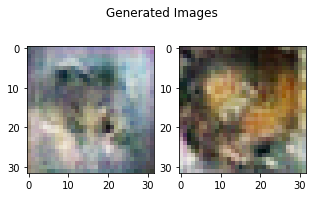

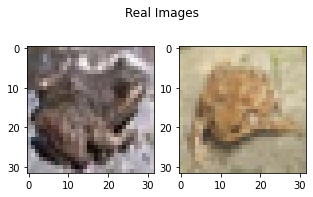

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
plt.subplot(1, 2, 1)
img = '../datasets/gan_images/generated_frog8200.png'
img = image.load_img(img)
plt.imshow(img)
plt.subplot(1, 2, 2)
img = '../datasets/gan_images/generated_frog8800.png'
img = image.load_img(img)
plt.imshow(img)

plt.suptitle('Generated Images')



plt.figure(figsize=(5, 3))
plt.subplot(1, 2, 1)
img = '../datasets/gan_images/real_frog8200.png'
img = image.load_img(img)
plt.imshow(img)
plt.subplot(1, 2, 2)
img = '../datasets/gan_images/real_frog8800.png'
img = image.load_img(img)
plt.imshow(img)

plt.suptitle('Real Images')
plt.show()

- 훈련할 때 적대적 손실이 크게 증가, 판별자 손실은 0으로 향하면 판별자의 학습률을 낮추기 위해 판별자 드롭아웃 비율을 높여서 시도